In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [1]:
import re
from datetime import datetime,timedelta
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import traceback
import itertools
from scipy.optimize import minimize, differential_evolution
import matplotlib.pyplot as plt
import pytz
import statsmodels.api as sm
import warnings
from sklearn.linear_model import LinearRegression
warnings.filterwarnings('ignore')

In [13]:
my_data=pd.read_csv("ALLDATA.csv")
my_data=my_data.sort_index()

for x in ['US10','US5','US30']:
    my_data['MID|'+str(x)]=0.5*(my_data['ASK|'+str(x)]+my_data['BID|'+str(x)])
my_data=my_data.reset_index()

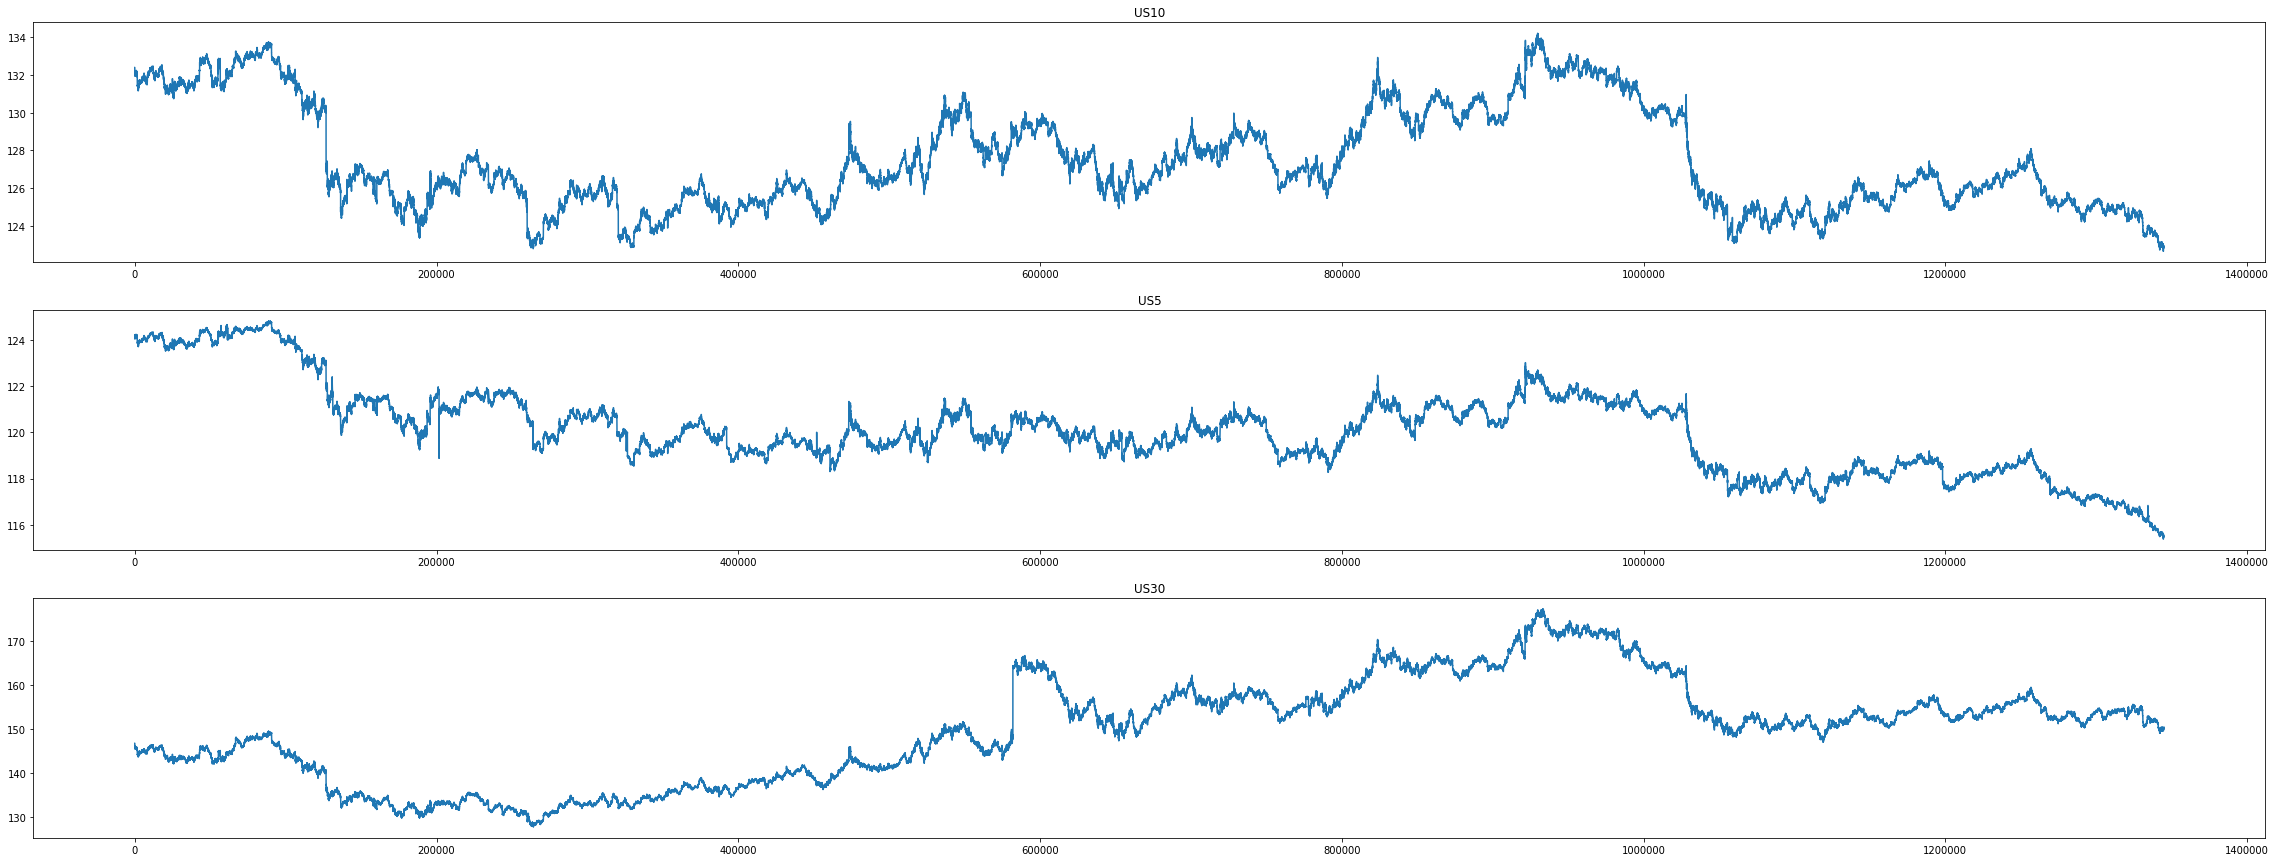

In [15]:

plt.figure(figsize=(40,15))
i=0
for x in ['US10','US5','US30']:
    i+=1
    plt.subplot(3,1,i)
    plt.title(str(x))
    plt.plot(my_data['MID|'+str(x)])
plt.show()

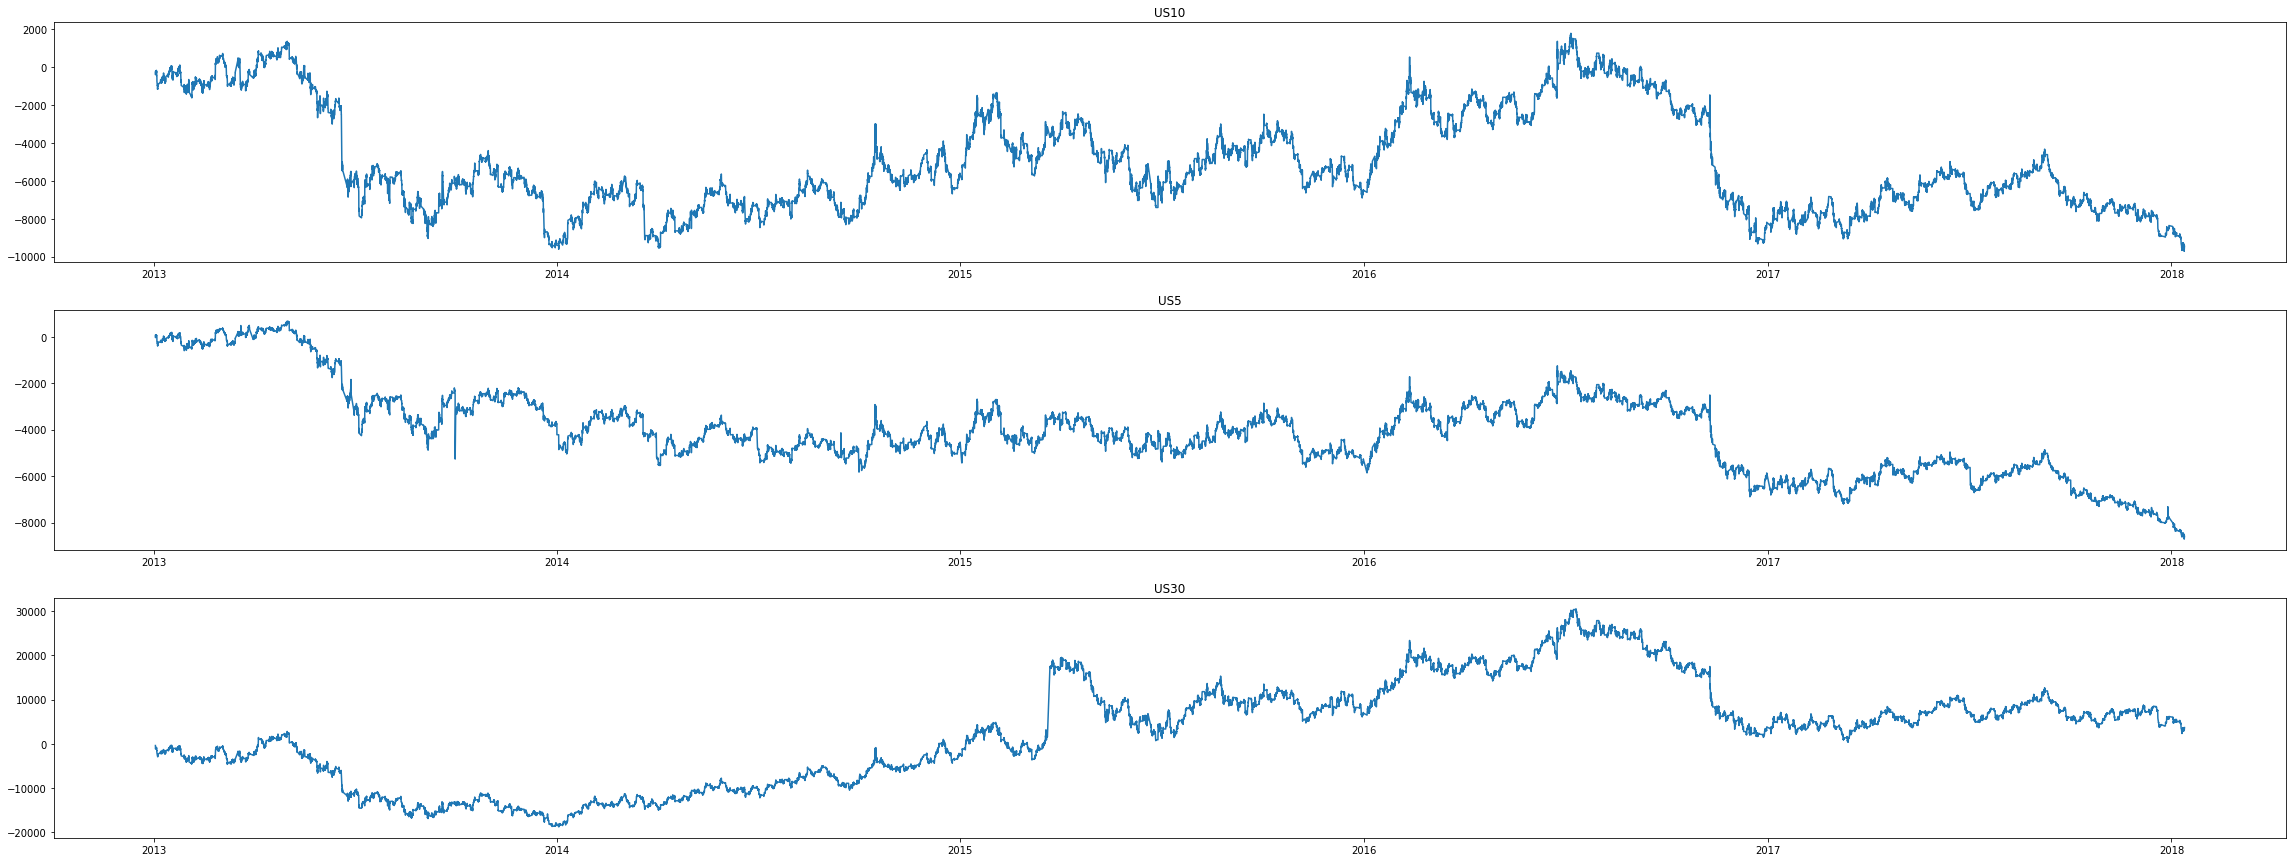

In [20]:
# CREATEE BARS

#BID ASK FOR EACH 

my_data=my_data[['Date', 'BID|US10', 'ASK|US10', 'USLOCAL', 'BID|US30', 'ASK|US30',
       'BID|US5', 'ASK|US5','AUSLOCAL', 'USROLL']]
my_data["Date"]=pd.to_datetime(my_data["Date"])

my_data=my_data.set_index("Date")
index_list=[]
for x in ["US5","US10","US30"]:
    for y in ["BID","ASK"]:
         
        item=(my_data[str(y)+"|"+str(x)].resample('1H',label='right',closed='right').ohlc().index)
        index_list.append(item)
flat_list = list(set([item for sublist in index_list for item in sublist]))

new_frame=pd.DataFrame(index=flat_list)
new_frame=new_frame.sort_index()



new_frame["close"]=0
for x in ["US5","US10","US30"]:
    for y in ["BID","ASK"]:
         
        dff=(my_data[str(y)+"|"+str(x)].resample('1H',label='right',closed='right').ohlc())
        dff=dff["close"]
        new_frame=new_frame.join(dff,rsuffix=str(y)+"|"+str(x))
        


my_data["TT"]=my_data.index
my_data["TT"]=my_data["TT"].astype(str).str.split(" ",expand=True)[0]
my_data=my_data.reset_index()
my_data=my_data.set_index(my_data["TT"])



new_frame["TT"]=new_frame.index
new_frame["TT"]=new_frame["TT"].astype(str).str.split(" ",expand=True)[0]
new_frame=new_frame.reset_index()
new_frame=new_frame.set_index(new_frame["TT"])

my_datas=my_data.copy()
my_datas=my_datas[["USROLL"]]
my_datas = my_datas[~my_datas.index.duplicated(keep='first')]



new_frame=new_frame.join(my_datas)

new_frame=new_frame.dropna()
new_frame=new_frame.set_index(new_frame["index"])
new_frame=new_frame.drop(["TT"],axis=1)
new_frame=new_frame.sort_index()
new_cols=[x.replace("close","") for x in new_frame.columns]
new_frame.columns=new_cols
for x in ['US10','US5','US30']:
    new_frame['MID|'+str(x)]=0.5*(new_frame['ASK|'+str(x)]+new_frame['BID|'+str(x)])




new_frame=new_frame.dropna()

US_TICK=31.25


new_frame["TH|US5"]=new_frame["TH|US10"]=new_frame["TH|US30"]=new_frame["TH|AU10"]=new_frame["TH|AU3"]=0
new_frame["TH|US5"]=new_frame["MID|US5"].diff()/(1/32)*US_TICK
new_frame["TH|US10"]=new_frame["MID|US10"].diff()/(1/32)*US_TICK
new_frame["TH|US30"]=new_frame["MID|US30"].diff()/(1/32)*US_TICK

new_frame=new_frame.dropna()

constant=0
new_frame["TH|US5"]=new_frame["TH|US5"].cumsum()+constant
new_frame["TH|US10"]=new_frame["TH|US10"].cumsum()+constant
new_frame["TH|US30"]=new_frame["TH|US30"].cumsum()+constant
plt.figure(figsize=(40,15))
i=0
for x in ['US10','US5','US30']:
    i+=1
    plt.subplot(3,1,i)
    plt.title(str(x))
    plt.plot(new_frame['TH|'+str(x)])
plt.show()




In [29]:
def get_feature_prices(input_array,features_bid,features_ask,ii):
    z=[]
    ss=0
    for x in input_array:
        if x==1:#features_b[:,i]
            z.append(features_bid[ss,ii])
        if x==-1:#features_b[:,i]
            z.append(features_ask[ss,ii])
        ss+=1
    return np.array(z)

def calc_profit(main_pos,input_array,entry_main_actual,exit_main_actual,entry_leg_actual,exit_leg_actual,coefficients):
    
   # print("-"*20,"PROFIT_CALC")
   # print("Coef:",coefficients)
    tot_prof=0
    zz=[]
    profits=[]
    if main_pos==1:
        #BUY THE MAIN, SELL THE LEGS
        main_profit=(exit_main_actual-entry_main_actual)/(1/32)*31.25
    elif main_pos==-1:
        main_profit=(-exit_main_actual+entry_main_actual)/(1/32)*31.25


    profits.append(main_profit)
    s=0
    for x in input_array:
        if x==1:
            leg_profit=(exit_leg_actual[s]-entry_leg_actual[s])/(1/32)*31.25*np.abs(coefficients[s])
        elif x==-1:
            leg_profit=(-exit_leg_actual[s]+entry_leg_actual[s])/(1/32)*31.25*np.abs(coefficients[s])
        s+=1
        profits.append(leg_profit)


    #print("coef ",coefficients)
    #print("positions main",main_pos,"positions leg",input_array)
    #print("Prices open_main:",entry_main_actual,"open leg1:",entry_leg_actual[0],"open leg2:",entry_leg_actual[1])
    #print("Prices close_main:",exit_main_actual,"close leg1:",exit_leg_actual[0],"close leg2:",exit_leg_actual[1])
    #print("Profit MAIN:",profits[0],"profit leg1:",profits[1],"profit leg2:",profits[2])
    #print("Total Profit:",np.sum(profits))
    #print("Comissions:",((np.sum(np.abs(coefficients)))+1)*2)
    return np.sum(profits)-1.6*((np.sum(np.abs(coefficients)))+1)*2




def backtest(bnd,TIME_EXIT,lkbk,MAX_LOOP,COMMS_MULTIPLIER):
    model = LinearRegression()
    

    #features = np.asarray([new_frame['TH|'+str(x)] for i,x in enumerate(['AU3','US10','AU10','US30'])])
    features = np.asarray([new_frame['TH|'+str(x)] for i,x in enumerate(['US10','US30'])])
    features_b = np.asarray([new_frame['MID|'+str(x)] for i,x in enumerate(['US10','US30'])])
    classifier = np.asarray(new_frame['TH|US5'])
    classifier_b = np.asarray(new_frame['MID|US5'])

    datesss=np.asarray(new_frame.index)
    
    features_bid = np.asarray([new_frame['BID|'+str(x)] for i,x in enumerate(['US10','US30'])])
    features_ask = np.asarray([new_frame['ASK|'+str(x)] for i,x in enumerate(['US10','US30'])])
    
    classifier_bid = np.asarray(new_frame['BID|US5'])
    classifier_ask = np.asarray(new_frame['ASK|US5'])
    
    
    roll_data=np.asarray(new_frame['USROLL'])
    inpos = 0
    cnt = 10000
    
    pnls = []
    dates = []
    residual=0
    curr_price=0
    op=0
    com_list=[]
    entry=0
    ttt=0
    stds=[]
    ppp=[]
    spread_list=[]
    #costs=[31*0.9+(1.6*2),16+(1.6*2),50*0.9+3.2,32+(1.6*2)]
    costs=[31.25/2+(1.6*2),31.25+(1.6*2)]    
    
    
    for i in range(lkbk+1,classifier.shape[0]-4):
        cnt += 1
        if  inpos==0 and cnt>MAX_LOOP:
            
            ft = features[:,i-lkbk:i]
            cl = classifier[i-lkbk:i]
 
            #testtt=[ft,cl]
            #return testtt
            model.fit(ft.T,cl)
            bw = np.std(residual)
            comissions=(np.sum(np.array(costs)*np.abs(model.coef_))+(31.25/4+(1.6*2)))
            comissions_real=comissions
            pos = 1#(np.abs(curr_price)/bw)
            cnt = 0
            
        if i>lkbk+3:
            curr_price = np.sum(model.coef_*features[:,i])-classifier[i]+model.intercept_
      
            residual = np.sum(model.coef_*features[:,i-lkbk:i].T,axis=1)-classifier[i-lkbk:i]+model.intercept_ 
            stds.append(curr_price)
            entry_spread1=features_ask[:,i]-features_bid[:,i]
            entry_spread2=classifier_ask[i]-classifier_bid[i]
            current_spread_list=[entry_spread1[0],entry_spread1[1],entry_spread2]
            spr_check=0
            logical_spreads=[((1/32)/2+(1/32)/4),((1/32)+(1/32)/2),((1/32)/4+(1/32)/8)]
            spr_check=0
            for log,spr in zip(logical_spreads,current_spread_list):
                if spr<log*5:
                    spr_check+=1
  
            #print(bw,curr_price)
            #print(datesss[i],curr_price,bw*bnd)

        if curr_price > bw*bnd and inpos == 0 and curr_price>comissions and spr_check==3:
            inpos = -1
            #print('short enter ',datesss[i])
            #print("Entry Price:",features_b[:,i],features[:,i],model.coef_)
            entry = curr_price
            op = i 
            entry_b1 =  features_b[:,i]
            entry_b2 = classifier_b[i]

            #BUY THE CLASSIFIER FROM ASK
            entry_b2_act=classifier_ask[i]
            
            
            input_array=(np.sign(model.coef_))
            entry_b1_act=get_feature_prices(input_array,features_bid,features_ask,i)

            
            
            #BUY THE WEIGHTS
            entry_spread1=features_ask[:,i]-features_bid[:,i]
            entry_spread2=classifier_ask[i]-classifier_bid[i]
            spread_list.append([entry_spread1[0],entry_spread1[1],entry_spread2])
                

            
        elif (i-op>TIME_EXIT and inpos==-1) or (inpos == -1 and (curr_price < -entry-comissions*COMMS_MULTIPLIER)):
            
            pnl = (-curr_price + entry)*pos
            pnl_b = (sum(entry_b1 * model.coef_) - entry_b2) - (sum(features_b[:,i]*model.coef_) - classifier_b[i])

            
     

            exit_b2_act=classifier_bid[i]
            input_array=(np.sign(model.coef_)*-1)
            exit_b1_act=get_feature_prices(input_array,features_bid,features_ask,i)
            
            pp=calc_profit(inpos*-1,input_array,entry_b2_act,exit_b2_act,entry_b1_act,exit_b1_act,model.coef_)
            inpos = 0

         
            entry_spread1=features_ask[:,i]-features_bid[:,i]
            entry_spread2=classifier_ask[i]-classifier_bid[i]
            spread_list.append([entry_spread1[0],entry_spread1[1],entry_spread2])
            
            ppp.append(pp)
            pnls.append(pnl-comissions_real*pos)
            dates.append(i)

            
            #print("Exit Price:",features_b[:,i],features[:,i],model.coef_,pnl-comissions_real*pos,)

        elif curr_price < -bw*bnd and inpos == 0  and curr_price<-comissions and spr_check==3:
            inpos = 1
            #print('long enter ',datesss[i])
            entry = curr_price
            op = i
            entry_b1 =  features_b[:,i]
            entry_b2 = classifier_b[i]

            #entry_b2_act=classifier_ask[i]
            #BSELL THE CLASSIFIER FROM BID
            entry_b2_act=classifier_bid[i]
            input_array=(np.sign(model.coef_)*-1)
            entry_b1_act=get_feature_prices(input_array,features_bid,features_ask,i)
            
            entry_spread1=features_ask[:,i]-features_bid[:,i]
            entry_spread2=classifier_ask[i]-classifier_bid[i]
            spread_list.append([entry_spread1[0],entry_spread1[1],entry_spread2])

            

        elif (i-op>TIME_EXIT and inpos==1) or (inpos == 1 and (curr_price > entry+comissions*COMMS_MULTIPLIER)):

            pnl = (curr_price - entry)*pos
            pnl_b = -(sum(entry_b1 * model.coef_) - entry_b2) + (sum(features_b[:,i]*model.coef_) - classifier_b[i])
           # print(pnl-comissions_real*pos)

            pnls.append(pnl-comissions_real*pos) 
            dates.append(i)
            #exit_b2_act=classifier_bid[i]
            #BUY THE CLASSIFIER FROM ASK
            exit_b2_act=classifier_ask[i]
            input_array=(np.sign(model.coef_))
            exit_b1_act=get_feature_prices(input_array,features_bid,features_ask,i)
            
            pp=calc_profit(inpos*-1,input_array,entry_b2_act,exit_b2_act,entry_b1_act,exit_b1_act,model.coef_)
   
            
            
            ppp.append(pp)
            inpos = 0

            entry_spread1=features_ask[:,i]-features_bid[:,i]
            entry_spread2=classifier_ask[i]-classifier_bid[i]
            spread_list.append([entry_spread1[0],entry_spread1[1],entry_spread2])
            


    
    return dates,ppp,spread_list,pnls



[-118.54130380803556, -92.94469117471424, -125.50898954645217, 446.49975025990676, -3.7100808448225946, 4.693176179597589, 28.547063393801142, -332.86521159119314, 94.18403538052955, 11.172807716015502, -255.89027488298322, -213.52644269441694, 192.24620910610406, -19.21375603487056, 46.64444968164511, 73.0632402483399, -61.01080790041301, -91.30190703339102, -36.08972709014131, 388.8887291593164, -22.495902548699632, 94.2397484296918, 14.096458351696365, -7.677318400234325, -30.10623597352628, -26.679394026670025, -18.717732255531807, -13.775340797288587, -8.182172225878025, -10.800347872040883, -144.7717172944665, 222.3013228394864, 224.20582663129278, 79.23817179717544, -185.20490798193336, -55.93709881536908, 67.75021484112327, 0.0993419183060853, 47.87100646705464, 24.145524863078478, 10.11140112898102, 9.52833469371876, 7.303978089735812, 5.388966048892536, 74.77103652307353, -87.48386731284413, 1185.1501653616187, 780.3721262622538, 142.56346243763835, -484.2428145735406, 5.9716

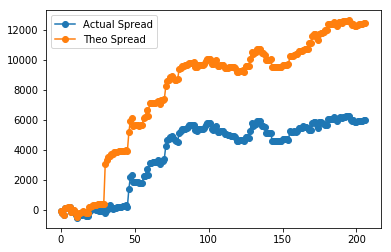

NameError: name 'sss' is not defined

In [30]:
for B in range(1,6):
    
    tls =[]
    for Z in range(1,11):
        for T in range(1,6):
            for F in range(3,5):
                aa=np.random.randint(100,500)
                bb=np.random.randint(100,500)
                cc=np.random.randint(50,200)
                dd=np.random.rand()*1.5+1
                #print(bnd,aa,bb,cc,dd)
               # dates,com_pnls,sprr,pnls  = backtest(bnd,aa,bb,cc,dd)
                dates,com_pnls,sprr,pnls=backtest(1,236,288,136,1.1333257746892431)
                print(com_pnls)
                #dates,com_pnls,sprr,pnls = backtest(B,Z*100,Z*100,100*T,0.5*F)
                #dates,pnls = backtest(bnd=1,TIME_EXIT=200,lkbk=1000,MAX_LOOP=100,COMMS_MULTIPLIER=1)
                plt.plot(np.cumsum(com_pnls),'-o',label="Actual Spread")
                plt.plot(np.cumsum(pnls),'-o',label="Theo Spread")
                plt.legend()
                plt.show()
                print(sss)
                #testttt = backtest(bnd,aa,bb,cc,dd)
                #mesttt=backtest_yigit(new_frame,bnd,aa,bb,cc,dd)
                #print(testttt[0]==mesttt[0])
                #print(testttt[1]==mesttt[1])

                tls.append(pd.Series(com_pnls,index=dates))



df = pd.DataFrame(tls)
plt.plot(df.sum(axis=0).cumsum(),'-o')
plt.show()



index        BID|US5     ASK|US5  \
index                                                                
2013-03-31 23:00:00 2013-03-31 23:00:00  0  124.015625  124.023438   
2013-06-30 23:00:00 2013-06-30 23:00:00  0  120.976562  120.984375   
2013-09-30 00:00:00 2013-09-30 00:00:00  0  121.898438  121.968750   
2013-12-31 00:00:00 2013-12-31 00:00:00  0  120.351562  120.546875   
2014-03-31 00:00:00 2014-03-31 00:00:00  0  119.648438  120.054688   
2014-06-30 00:00:00 2014-06-30 00:00:00  0  120.156250  120.250000   
2014-09-30 00:00:00 2014-09-30 00:00:00  0  119.273438  119.429688   
2014-12-31 00:00:00 2014-12-31 00:00:00  0  119.320312  119.523438   
2015-03-31 00:00:00 2015-03-31 00:00:00  0  120.656250  120.796875   
2015-06-30 00:00:00 2015-06-30 00:00:00  0  119.859375  119.960938   
2015-09-30 00:00:00 2015-09-30 00:00:00  0  120.765625  120.812500   
2015-12-31 00:00:00 2015-12-31 00:00:00  0  118.710938  118.765625   
2016-03-31 00:00:00 2016-03-31 00:00:00  0  121.242188  121.328125   
2016-06-30 00:00:00 2016-06-30 00:00:00  0  122.242188  122.281250   
2016-09-30 00:00:00 2016-09-30 00:00:00  0  121.726562  121.765625   
2017-03-31 00:00:00 2017-03-31 00:00:00  0  117.914062  117.992188   
2017-06-30 00:00:00 2017-06-30 00:00:00  0  118.539062  118.679688   

                       BID|US10    ASK|US10   BID|US30   ASK|US30  USROLL  \
index                                                                       
2013-03-31 23:00:00  131.812500  131.828125  144.21875  144.25000     1.0   
2013-06-30 23:00:00  126.437500  126.453125  135.68750  135.71875     1.0   
2013-09-30 00:00:00  126.625000  126.640625  133.68750  133.71875     1.0   
2013-12-31 00:00:00  123.187500  123.203125  128.75000  128.78125     1.0   
2014-03-31 00:00:00  123.406250  123.421875  133.37500  133.40625     1.0   
2014-06-30 00:00:00  125.109375  125.125000  136.90625  136.93750     1.0   
2014-09-30 00:00:00  124.828125  124.843750  138.46875  138.50000     1.0   
2014-12-31 00:00:00  126.578125  126.593750  144.25000  144.28125     1.0   
2015-03-31 00:00:00  128.671875  128.687500  163.65625  163.68750     1.0   
2015-06-30 00:00:00  126.250000  126.265625  151.03125  151.06250     1.0   
2015-09-30 00:00:00  128.703125  128.718750  157.68750  157.71875     1.0   
2015-12-31 00:00:00  125.687500  125.703125  153.43750  153.46875     1.0   
2016-03-31 00:00:00  130.125000  130.140625  163.75000  163.78125     1.0   
2016-06-30 00:00:00  132.781250  132.796875  172.09375  172.12500     1.0   
2016-09-30 00:00:00  131.546875  131.562500  169.56250  169.59375     1.0   
2017-03-31 00:00:00  124.375000  124.390625  150.56250  150.59375     1.0   
2017-06-30 00:00:00  125.843750  125.859375  154.25000  154.28125     1.0   

                       MID|US10     MID|US5    MID|US30      TH|US5   TH|US10  \
index                                                                           
2013-03-31 23:00:00  131.820312  124.019531  144.234375  -117.18750  -578.125   
2013-06-30 23:00:00  126.445312  120.980469  135.703125 -3156.25000 -5953.125   
2013-09-30 00:00:00  126.632812  121.933594  133.703125 -2203.12500 -5765.625   
2013-12-31 00:00:00  123.195312  120.449219  128.765625 -3687.50000 -9203.125   
2014-03-31 00:00:00  123.414062  119.851562  133.390625 -4285.15625 -8984.375   
2014-06-30 00:00:00  125.117188  120.203125  136.921875 -3933.59375 -7281.250   
2014-09-30 00:00:00  124.835938  119.351562  138.484375 -4785.15625 -7562.500   
2014-12-31 00:00:00  126.585938  119.421875  144.265625 -4714.84375 -5812.500   
2015-03-31 00:00:00  128.679688  120.726562  163.671875 -3410.15625 -3718.750   
2015-06-30 00:00:00  126.257812  119.910156  151.046875 -4226.56250 -6140.625   
2015-09-30 00:00:00  128.710938  120.789062  157.703125 -3347.65625 -3687.500   
2015-12-31 00:00:00  125.695312  118.738281  153.453125 -5398.43750 -6703.125   
2016-03-31 00:00:00  130.132812  121.285156  163.765625 -2851.56250 -2265.625   
2016-06-30 00:00:00  132

In [1]:
total_iter=len(BANDWIDTHS)*len(COMBINS)*len(LOOKBACKS)*len(TIME_EXITS)*len(COMISSION_THOLD)*len(MAX_LOOPS)

NameError: name 'BANDWIDTHS' is not defined